# Exploring venues in Indore, India

## Table of Contents

* [Introduction](#introduction)
* [Data Collection from APIs](#data_collection)
* [Data Cleaning](#data_cleaning)
* [Methodolgy](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The aim of the project is to identify venues in Indore, Madhya Pradesh, India based on their rating and average prices. In this notebook, we will identify various venues in the city of **Indore, India**, using **Foursquare API** and **Zomato API**, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll **identify places that are fit for various individuals** based on the information collected from the two APIs using data science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

## Data Collection from APIs <a name="data_collection"></a>

To begin with, we will take a look at **Indore on the Map** using the `folium` library.

We will also fetch the data from **two different APIs**.
* **Foursquare API:** We will use the Foursquare API to fetch venues in Indore starting from the middle upto 7 Kilometers in each direction.
* **Zomato API:** The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.

### Indore

**Indore** is composed of a number of sectors. There are many venues (especially restaurants, hotels and cafes) which can be explored.

We are directly assigning the coordinates of indore in this project.

In [92]:
IDR_LATITUDE = 22.7196
IDR_LONGITUDE = 75.8577
print('The geograpical coordinates of Indore are {}, {}.'.format(CHD_LATITUDE, CHD_LONGITUDE))

The geograpical coordinates of Indore are 22.7196, 75.8577.


Let's use the `folium` library to create a **complete map zoomed on Indore**. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering. 

In [93]:
import folium

indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)
folium.Marker([IDR_LATITUDE, IDR_LONGITUDE]).add_to(indore_map)
indore_map

### Foursquare API

We begin by fetching a total of all venues in **Indore** upto a range of 4 Kilometers using the Foursquare API. The Foursquare API has the `explore` API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

In [100]:
#hidden cell
FOURSQUARE_CLIENT_ID = 'DAQGXEQFWATQ5DHZVUP5IPBPM3CCDQVEQEVWNJPZWI1WFMHI' # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = '2XTKTRFJOB2S0HTEOJXKBL0Q3L3FJ2MUD2Z334E5TT0KYWS5' # your Foursquare Secret
VERSION = '20200101' # Foursquare API version
RADIUS = 5000 # 7 Km
NO_OF_VENUES = 100

We define the `get_category_type` method to get the correct category for each venue.

In [101]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

* Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account. 
* We will set the radius as 7 Kilometers. 
* The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.

In [102]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        CHD_LATITUDE, 
                                                                        CHD_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 61 venues fetched within a total radius of 5.0 Km

Total 61 venues fetched


### Zomato API

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the `name`, `lat`, and `lng` values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

* The query will be the name of the venue.
* The start defines from what offset we want to start, so we'll keep it at 0.
* The count defines the number of restaurants we want to fetch. As we have the exact location coordinates, we'll fetch only one.
* We will supply the latitude and longitude values.
* We will set the sorting criteria as `real_distance` so each time we get the venue we're searching based on location coordinates.

In [103]:
headers = {'user-key': 'b3a1c26ed20422bfaae7ada558744e1f'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

## Data Cleaning <a name="data_cleaning"></a>

The data from multiple resources might not always align. Thus, it is **important to combine the data retrieved from multiple resources properly**.

We'll first plot the two data points on the map. We'll then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, we will inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before we begin any analysis.

We will first plot the Foursquare data on the map.

In [106]:
indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(indore_map)  

indore_map

From the map, we can infer that there are clusters of venues around **Mahatma Gandhi Marg** and **Race Course Road**. We can also plot the category count and see the major type of venues that exist.

We will also plot the Zomato data on the map.

In [109]:
indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    print(longitude)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(Indore_map)    


indore_map

75.8722032979


TypeError: must be real number, not str

We can see that there are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near MG Marg and Race Course Road. However, there are others where the data does not match just like the red dots in the bottom right on the second map.

To combine the two datasets, I'll have to check that the latitude and longitude values of each corresponding venue match. Thus, I'll round both the latitude and longitude values upto 4 decimal places. Then, I'll calculate the difference between the corresponding latitude and longitude values and see if the difference is less than 0.0004 which should ideally mean that the two locations are same.

In [110]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [111]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [112]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Shreemaya Hotel Indore,Hotel,22.7151,75.8746,Cheers Cafe,22.7152,75.8749,200.0,1.0,3.0,"G-1/1, Sapna Chamber, 12/1, RNT Marg, Indore",0.0001,0.0003
1,56 Dukan,Plaza,22.7241,75.8848,Chaap Adda,22.7241,75.8848,300.0,1.0,3.6,"Shop 56, Lower Ground 02, One Centre, New Pala...",0.0000,0.0000
2,Bablu Sandwich,Sandwich Place,22.7036,75.8554,Prem Prakash,22.7035,75.8555,350.0,2.0,3.7,"Prem Nagar Square, Manik Bagh Overbridge Corne...",-0.0001,0.0001
3,Lotus Hut Cafe,Coffee Shop,22.7209,75.8759,Lotus Hut,22.7209,75.8759,350.0,2.0,3.9,"17, MG Road, South Tukoganj, Indore",0.0000,0.0000
4,Top n town,Ice Cream Shop,22.7257,75.8774,Top 'N' Town,22.7257,75.8775,200.0,1.0,4.1,"14/8, Race Course Road, YN Road, Indore",0.0000,0.0001
5,"Ccd,apollo Square",Café,22.7264,75.8810,Cafe Coffee Day,22.7262,75.8810,500.0,2.0,3.7,"Apollo Square, Race Course Road, Near Janjeerw...",-0.0002,0.0000
6,Tinku Ice Cream,Ice Cream Shop,22.7213,75.8739,Sheetal Gazak & Kulfi,22.7209,75.8739,250.0,1.0,4.1,"Near Rajani Bhawan, YN Road, Indore",-0.0004,0.0000
7,Cafe Palette,Café,22.7214,75.8875,Coksa Cafe,22.7214,75.8872,250.0,1.0,0,"24/2, Manorama Ganj, Near Sanghi Motors, Geeta...",0.0000,-0.0003
8,Mr Beans,Cafeteria,22.7233,75.8969,Mr. Beans,22.7232,75.8967,800.0,3.0,4.3,"100, Saket, Old Palasia, Indore",-0.0001,-0.0002
9,Celebrations Shreemaya,Restaurant,22.7153,75.8751,Hotel Shreemaya,22.7152,75.8750,1100.0,3.0,4.4,"12, South Tukoganj, RNT Marg Indore",-0.0001,-0.0001


Taking a look at the names of venues from both APIs, some names are a complete mismatch.

**Category 1:** There are venues that have specific restaurants/cafes inside them as provided by Zomato API .

**Category 2:** Two locations are so close by that they have practically same latitude and longitude values 

**Category 3:** Some have been replaced with new restaurants.

The venues which belong to category 1 and category 3 are alright to keep, the venues that fall in category 2 should be removed.

In [113]:
selected_venues = selected_venues.drop([0, 3, 5, 9, 12, 14, 17, 19, 21]).reset_index(drop = True)

I'll now select the venue name from **Zomato API**. I'll also get the average price per person by dividing the column `price_for_two` by 2 and removing this column from the dataset along with other unnecessary columns.

In [114]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

Let's take a look at the final dataset that is left with us.

In [115]:
selected_venues.head(5)

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.6,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0
1,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.7,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0
2,Ice Cream Shop,Top 'N' Town,22.7257,75.8775,1.0,4.1,"14/8, Race Course Road, YN Road, Indore",100.0
3,Ice Cream Shop,Sheetal Gazak & Kulfi,22.7209,75.8739,1.0,4.1,"Near Rajani Bhawan, YN Road, Indore",125.0
4,Café,Coksa Cafe,22.7214,75.8872,1.0,0,"24/2, Manorama Ganj, Near Sanghi Motors, Geeta...",125.0


I'll drop the venues which have `0.0` rating as it means it's not been rated yet.

In [116]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 19


## Methodology <a name="methodology"></a>

This project aims at identifying the venues in Indore based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the **data from two APIs (Foursquare and Zomato)**. We extract venue information from the center of Indore, upto a distance of 4 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then **explored the data** retrieved from the two APIs on the map and identified the top category types. The **data from the two sources is carefully combined** based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll **analyse the data** that we created based on the ratings and price of each venue. We'll **identify places where many venues are located** so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore **areas that are high rated and those that are low rated** while also plotting the **map of high and low priced venues**. Lastly, we'll **cluster the venues** based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## Analysis <a name="analysis"></a>

The complete dataset is now in its final form. 

We will **inspect these venues based on their rating**. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also **analyse the venues based on their price per person as well as the price range**. 

### Categories

We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 15 artists>

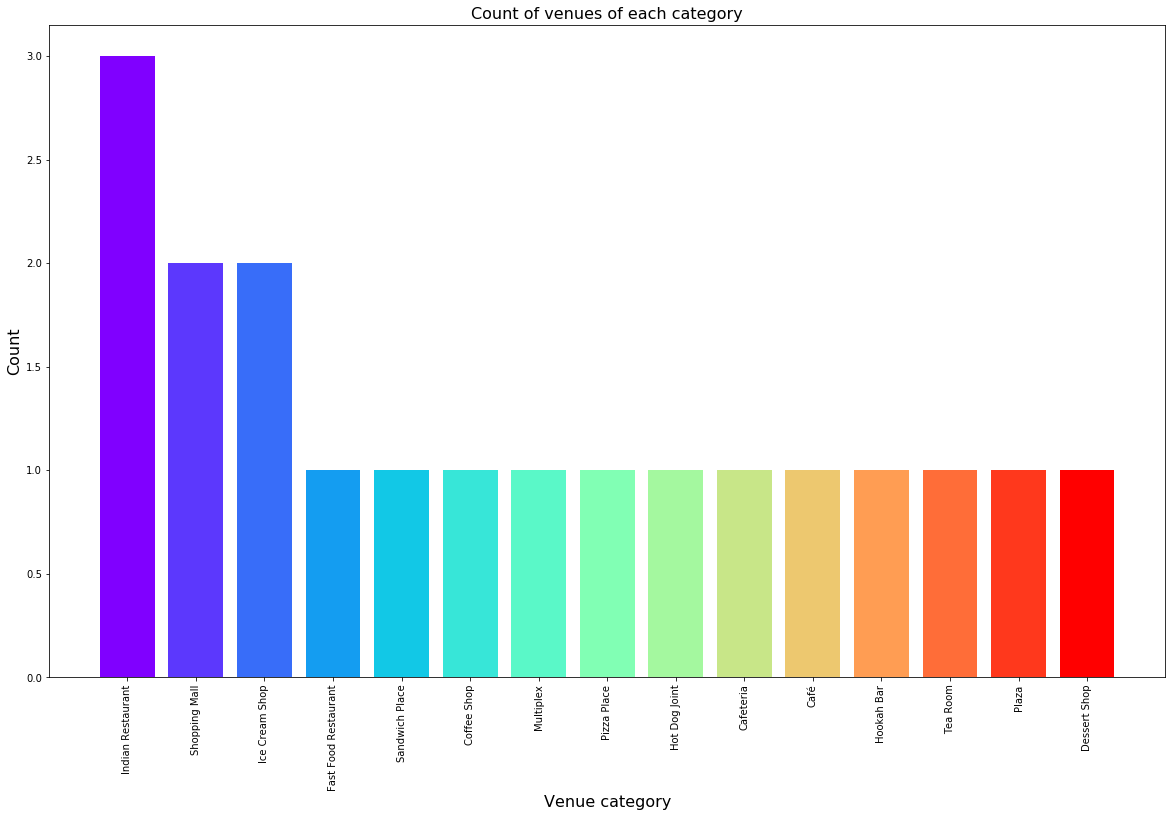

In [117]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are **Shopping mall** and **Indian Restaurant**. So, if as a tourist, you're looking for cafes and Indian restaurants, you're in luck.

### Rating

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

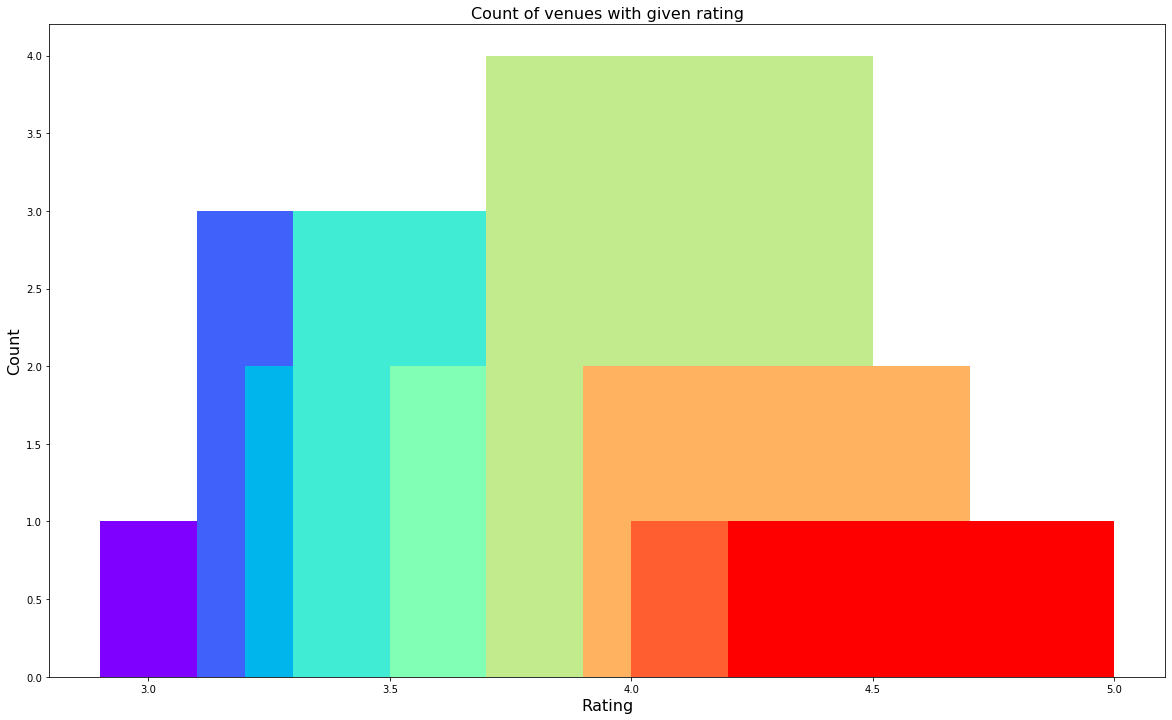

In [118]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that **majority venues** have their **rating close to 4**.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
* 1 to 2
* 2 to 3
* 3 to 4
* 4 to 5

In [119]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [120]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(indore_map)  


indore_map

The map has the location of all the venues. It appears that many venues are located near about **MG Road** and **Race Course Road ** with rating above 3. If someone wants to explore new venues, they should definitely check out these places.

### Price

We will now take a look the venues based on the price values. We have two price features for our venues, one is `average_price` which defines the average cost for one person and the other is `price_range` which determines the price range as defined by Zomato.

We will first explore the `average_price` using a scatter plot between the price and the count of venues with that average price. We'll size the points based on the price to highlight their price.

Text(0.5, 1.0, 'Count of venues with given average price')

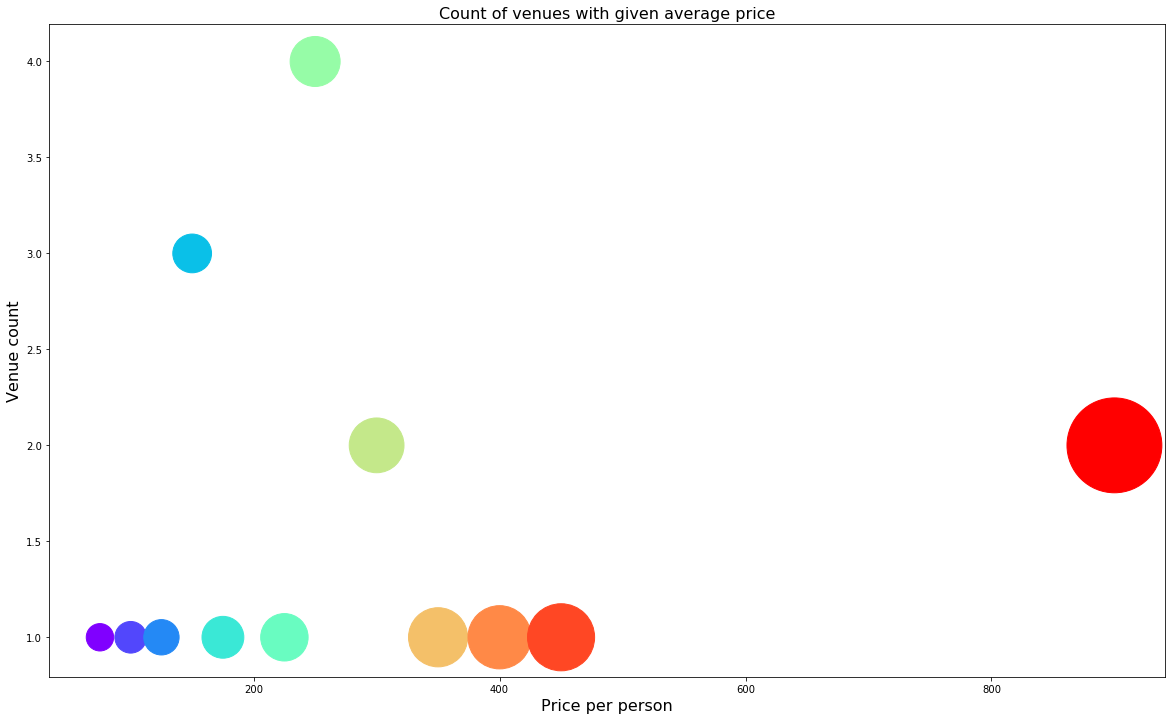

In [122]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

From the plot above we can see that a large number of venues have an average price between Rs 200 and Rs 400.

Users might also be interested in going to a place that fits in their budget. I'll use the `price_range` column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [124]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(indore_map)  

#Indore_map.save("maps/Venues Prices.html")
indore_map

### Clustering

We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [125]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(5)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.6,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0,Good
1,0,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.7,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0,Good
2,0,Ice Cream Shop,Top 'N' Town,22.7257,75.8775,1.0,4.1,"14/8, Race Course Road, YN Road, Indore",100.0,Very good
3,0,Ice Cream Shop,Sheetal Gazak & Kulfi,22.7209,75.8739,1.0,4.1,"Near Rajani Bhawan, YN Road, Indore",125.0,Very good
5,0,Cafeteria,Mr. Beans,22.7232,75.8967,3.0,4.3,"100, Saket, Old Palasia, Indore",400.0,Very good


In [129]:
indore_map = folium.Map(location = [IDR_LATITUDE, IDR_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(indore_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(indore_map)

indore_map

From the map, we see the two clusters:
1. The first cluster is spread across the whole city and includes the majority venues.
2. The second cluster is very sparsely spread and has very limited venues.

I'll also check the venues of the two clusters.

In [130]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Plaza,Chaap Adda,22.7241,75.8848,1.0,3.6,"Shop 56, Lower Ground 02, One Centre, New Pala...",150.0,Good
1,0,Sandwich Place,Prem Prakash,22.7035,75.8555,2.0,3.7,"Prem Nagar Square, Manik Bagh Overbridge Corne...",175.0,Good
2,0,Ice Cream Shop,Top 'N' Town,22.7257,75.8775,1.0,4.1,"14/8, Race Course Road, YN Road, Indore",100.0,Very good
3,0,Ice Cream Shop,Sheetal Gazak & Kulfi,22.7209,75.8739,1.0,4.1,"Near Rajani Bhawan, YN Road, Indore",125.0,Very good
4,0,Cafeteria,Mr. Beans,22.7232,75.8967,3.0,4.3,"100, Saket, Old Palasia, Indore",400.0,Very good
5,0,Coffee Shop,Cafe Coffee Day,22.6977,75.8772,2.0,3.7,"BCM City Building, AB Road, Near Navalakha Squ...",250.0,Good
6,0,Shopping Mall,Cafe Coffee Day,22.7362,75.8911,2.0,3.3,"Inside Hotel Ginger, Near Shoppers Stop Buildi...",250.0,Good
7,0,Indian Restaurant,The Roof,22.7240,75.8856,3.0,3.5,"Hotel Kanchan Tilak, 582/2, MG Road, New Palas...",450.0,Good
8,0,Tea Room,The Chai Bar,22.7253,75.8830,1.0,3.9,"G 1, Chetak Vihar, 7 R.S Bhandari Marg, Near 5...",150.0,Good
9,0,Hot Dog Joint,Johny Hot Dog,22.7245,75.8844,1.0,4.6,"Shop UD-49-50-51, Arcade Silver 56/1, New Pala...",75.0,Very good


In [131]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 1.76 and rating spread around 3.94


In [132]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hookah Bar,Sky Blue Sports Bar,22.7441,75.8942,4.0,3.5,"3rd Floor, C21 Mall, AB Road, Vijay Nagar, Indore",900.0,Good
1,1,Shopping Mall,Sky Blue Sports Bar,22.7441,75.8942,4.0,3.5,"3rd Floor, C21 Mall, AB Road, Vijay Nagar, Indore",900.0,Good


In [133]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 3.50


#### Results and Discussion <a name="results"></a>

Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of Indore, India.

After collecting data from the **Foursquare** and **Zomato** APIs, we got a list of 61 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers.

We identified that from the total set of venues, majority of them were **Shopping mall** and **Indian Restaurants**. A visitor who loves mall/Indian Restaurants would surely benefit from coming to Indore.

While the complete range of ratings range from 1 to 5, the **majority venues have ratings close to 4**. This means that most restaurants provide **good quality food** which is liked by the people of the city, thus indicating the high rating. When we plot these venues on the map, we discover that there are clusters of venues around **MG Road and Race Course Road**. These clusters also have very **high ratings (more than 3)**.

When we take a look at the price values of each venue, we explore that **many venues** have prices which are in the **range of Rs 200 to Rs 400 for one person**. However, the variation in prices is very large, given the complete range starts from Rs 100 and goes uptil Rs 1200. On plotting the venues based on their price range on the map, we discovered that venues located near.

Finally, through clusters we identified that there are **many venues** which are **relatively lower priced but have an average rating of 3.57**. On the other hand, there are **few venues** which are **high priced and have average rating of 4.03**.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## Conclusion <a name="conclusion"></a>

The purpose of this project was to explore the places that a person visiting Indore could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are two major areas a person can visit: MG Road and Race Course Road Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.